# Scoring Segmentation

Dans ce core là, je vais effectuer la segmentation des clients des banques. La première étape consiste à lire les bibliothèques nécessaires. Nous utiliserons:

- pandas - pour manipuler des blocs de données
- numpy - fournissant une algèbre linéaire
- seaborn - pour créer de jolies visualisations
- matplotlib - outils de base pour les visualisations
- scikit-learn - bibliothèque d'apprentissage automatique

A partir du sklearn, j'importerai les outils de prétraitement nécessaires et deux algorithmes de clustering: KMeans et Affinity Propagation.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Lire les données brutes

In [24]:
data = pd.read_csv("Upload_Data\Bank_Customer_data.csv")

Un contrôle visuel des cinq premières lignes.

In [25]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Il semble que la première colonne est simplement un index que nous pouvons supprimer. Je vais vérifier le nombre de valeurs manquantes dans chaque colonne et de quels types de données il s'agit.

In [26]:
data.drop(data.columns[0], inplace=True, axis=1)
print("La base de données a {} observations (clients) et {} colonnes (attributs).".format(data.shape[0],data.shape[1]))
print("Valeurs manquantes dans chaque colonne:\n{}".format(data.isnull().sum()))
print("Types de données de colonnes:\n{}".format(data.dtypes))

La base de données a 1000 observations (clients) et 9 colonnes (attributs).
Valeurs manquantes dans chaque colonne:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Types de données de colonnes:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Sur 8 colonnes, 2 contiennent des valeurs manquantes. Il s'agit probablement de clients qui ne possèdent pas l'un de ces deux comptes.

Généralement, il existe 3 variables numériques et 5 variables catégorielles.

Maintenant, je vais vérifier combien et quelles sont les valeurs (uniques) possibles dans chaque colonne catégorielle.

In [27]:
n_unique = data.nunique()
print("Nombre de valeurs uniques:\n{}".format(n_unique))

Nombre de valeurs uniques:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [28]:
print("Valeurs uniques dans chaque colonne catégorielle:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Valeurs uniques dans chaque colonne catégorielle:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## L'analyse exploratoire des données

Ci-dessous, je définirai une fonction qui générera des graphiques pour trois variables numériques avec stratification par colonne catégorielle sélectionnée.

In [29]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

Au début, examinons les diagrammes de dispersion de nos 3 variables numériques stratifiées par sexe.

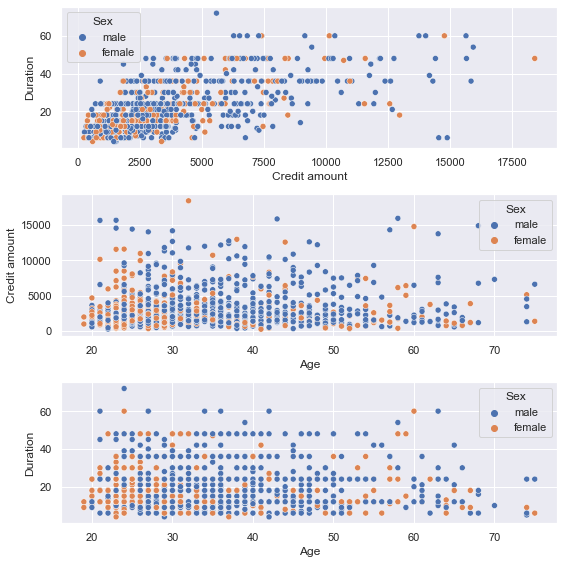

In [30]:
scatters(data, h="Sex")

L'impression générale est que les femmes ont tendance à être plus jeunes que les hommes, cependant, le graphique du haut montre qu'il n'y a pas de différence claire entre les hommes et les femmes en termes de montant et de durée du crédit. De l'inspection visuelle, il semble qu'il existe une corrélation positive entre la durée et le montant du crédit, ce qui a du sens.

Vérifions la corrélation linéaire entre le montant du crédit et la durée

Lire data dans un dataframe pandas

In [31]:
data_frame = pd.DataFrame(data)

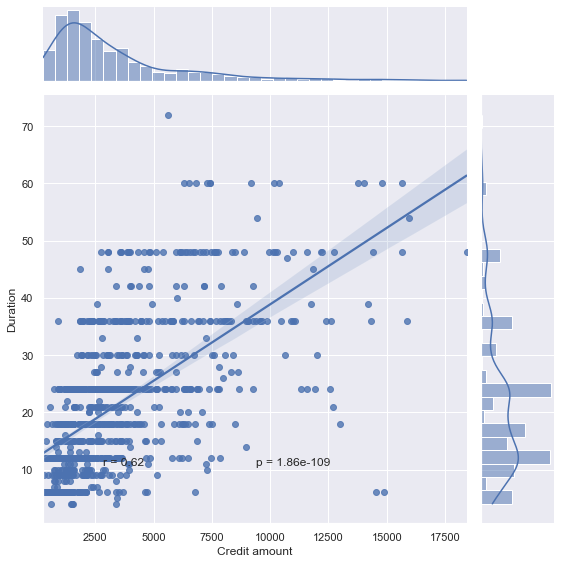

In [32]:
import scipy.stats as stats
x_data = data_frame['Credit amount']
y_data = data_frame['Duration']
sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot(x_data, y_data, data = data_frame, kind='reg', height=8)
r, p = stats.pearsonr(x_data, y_data)
#ax = plt.subplot()
# j.ax_joint me permet d'accéder à l'objet hache matplotlib, avec son
# méthodes et attributs associés
j.ax_joint.annotate('r = {:.2f} '.format(r), xy=(.1, .1), xycoords=ax.transAxes)
j.ax_joint.annotate('p = {:.2e}'.format(p), xy=(.4, .1), xycoords=ax.transAxes)
plt.show()

Le graphique ci-dessus montre une corrélation linéaire avec une valeur de Pearson de 0,62 et une très petite valeur p. Cela a du sens, car généralement, les gens prennent de plus gros crédits pendant de plus longues périodes. Ci-dessous, j'analyserai des graphiques de régression linéaire avec différentes catégorisations.

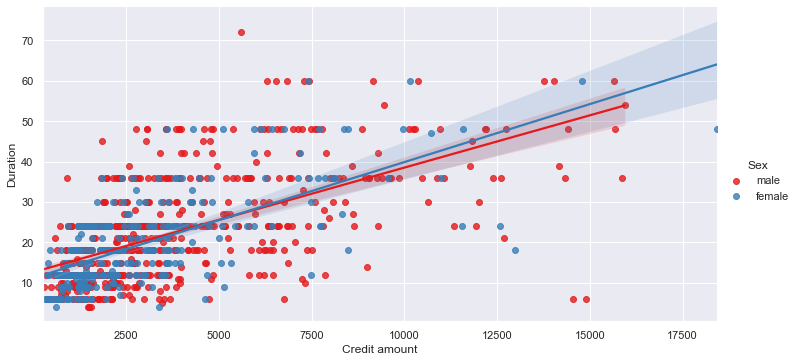

In [33]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

Le graphique ci-dessus indique qu'il n'y a pas de différence significative entre les hommes et les femmes.

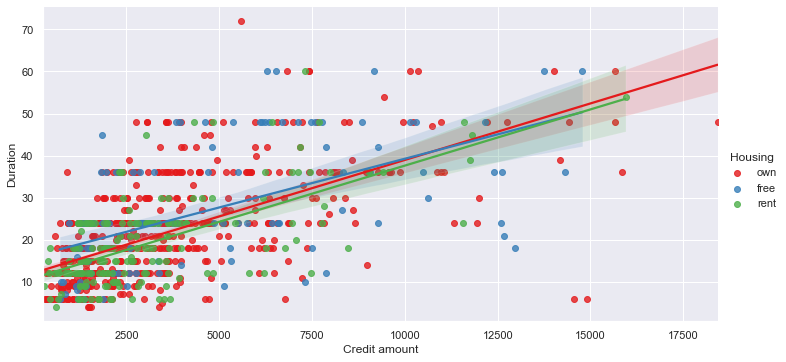

In [34]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data_frame, palette="Set1", aspect=2)
plt.show()

Le graphique ci-dessus montre de même qu'il n'y a pas de différence entre les catégories de logement. Ci-dessous, je montrerai la zone «business» où le plus grand nombre de crédits est accordé.

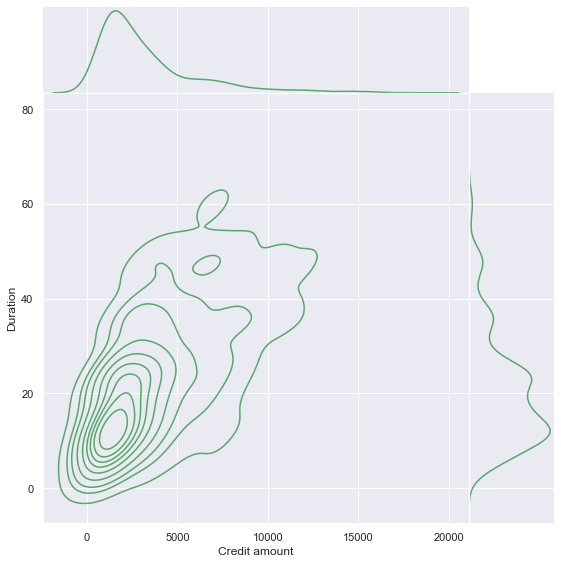

In [35]:
sns.jointplot("Credit amount","Duration", data=data_frame, kind="kde", space=0, color="g",  height=8)
plt.show()

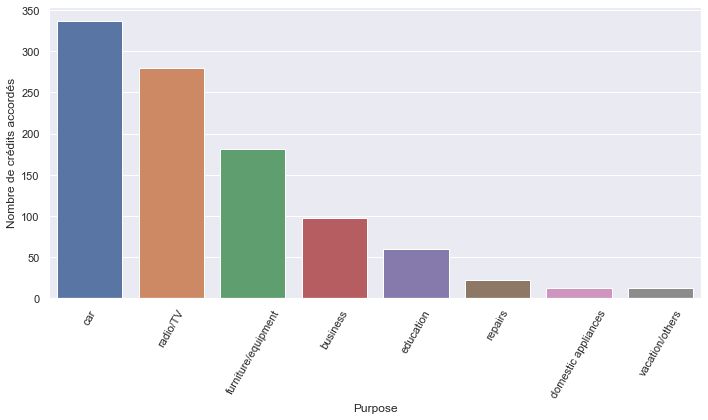

In [36]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Nombre de crédits accordés")
plt.tight_layout()

Le barplot ci-dessus montre combien de crédits ont été accordés à diverses fins. La plupart des crédits ont été accordés pour car et radio/TV.

Maintenant, je vais générer boxplots pour une analyse détaillée des variables catégorielles.

In [37]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

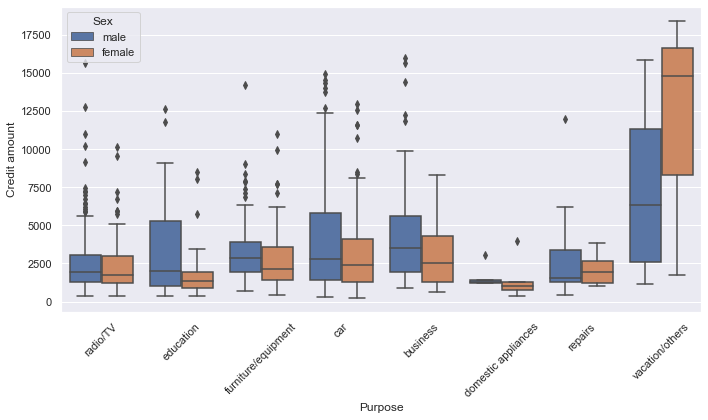

In [38]:
boxes("Purpose","Credit amount","Sex")

Le graphique ci-dessus montre que les plus grosses sommes sont prises pour les vacances / autres, les plus petites pour les appareils électroménagers. La plupart d'entre eux ont des valeurs aberrantes sur le côté supérieur des cases (montants plus élevés). Dans la plupart des cas, il n'y a pas de différence entre les hommes et les femmes, malgré la catégorie vacances / autres. Mais il faut se rappeler qu'il y avait très peu de crédits accordés dans cette catégorie.

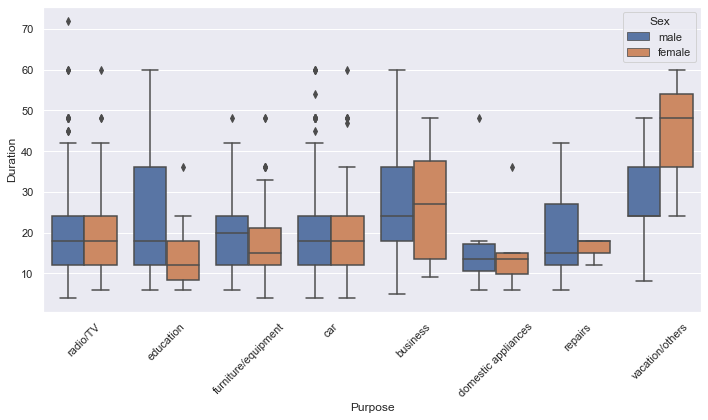

In [39]:
boxes("Purpose","Duration","Sex")

Le boxplot ci-dessus indique qu'il n'y a généralement pas de différence de durée de crédit entre les hommes et les femmes. Nous ne pouvons pas voir également de tendance claire entre les catégories avec des observations selon lesquelles la durée la plus courte concerne les appareils électroménagers. Cela a du sens car il est en accord avec les informations du graphique précédent (montant du crédit) - dans cette catégorie, il y a les montants de crédits les plus bas.

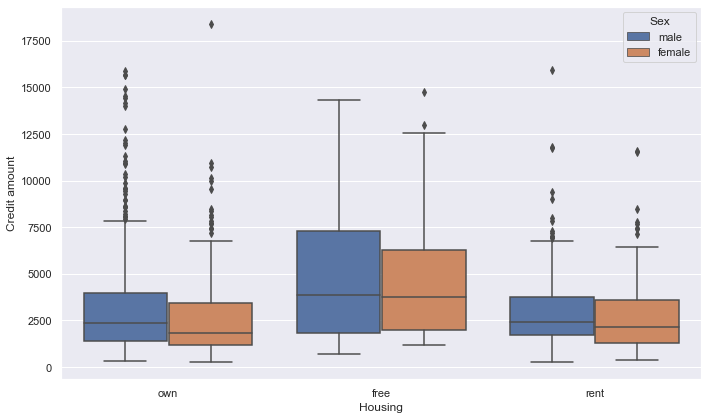

In [40]:
boxes("Housing","Credit amount","Sex",r=0)

En termes de catégorie de logement, il n'y a pas de grande différence, même si les personnes ayant un logement 'free' ont tendance à prendre des montants de crédit légèrement plus élevés.

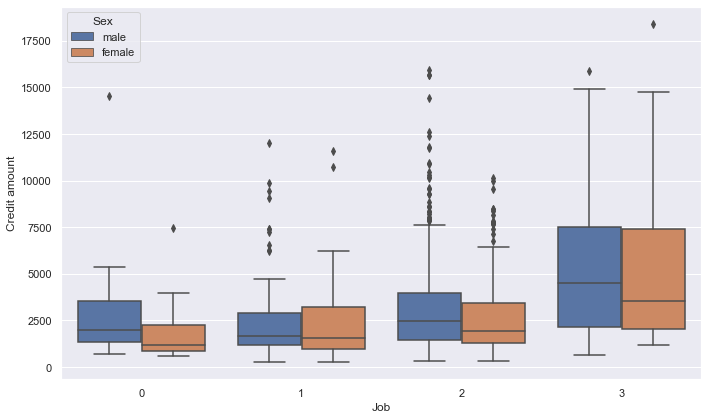

In [41]:
boxes("Job","Credit amount","Sex",r=0)

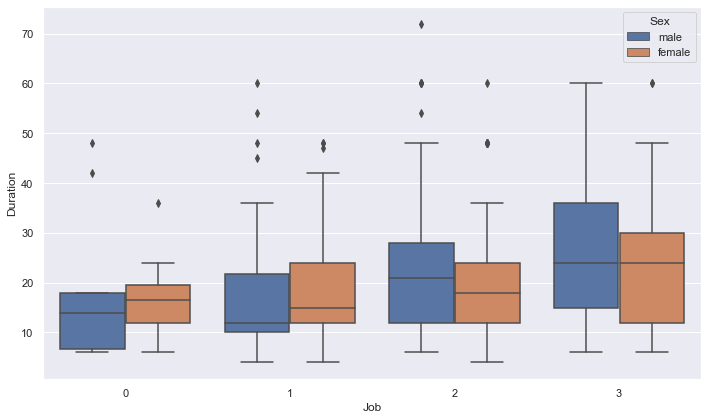

In [42]:
boxes("Job","Duration","Sex",r=0)

En termes de catégorie d'emploi, encore une fois, il n'y a pas de différence entre les hommes et les femmes, mais nous pouvons voir que la catégorie d'emploi 3 a tendance à recevoir des crédits plus importants pour une durée plus longue.

Et à la fin, si quelqu'un aime les tracés 3D, c'est parti.

Text(0.5, 0, 'Age')

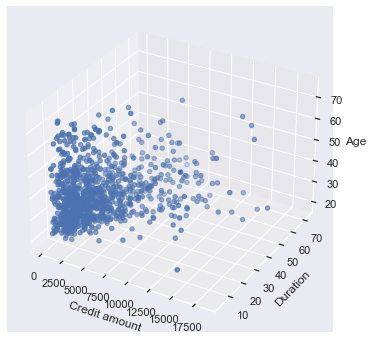

In [43]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

## Clustering avec KMeans

Pour le clustering, je vais créer un sous-ensemble contenant uniquement des variables numériques (Age, Credit amount, Duration).

In [44]:
#Sélection de colonnes pour la mise en cluster avec k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Je vais créer une fonction qui trace trois histogrammes - un pour chaque variable.

In [45]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

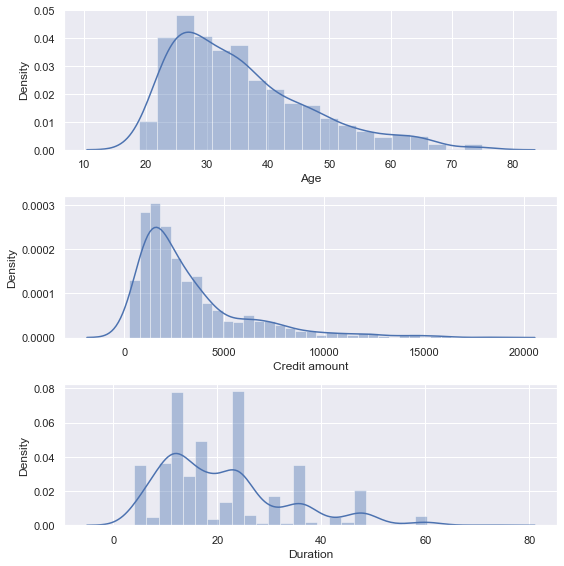

In [46]:
distributions(cluster_data)

Nous pouvons voir que les distributions sont oblique à droite. Pour obtenir de meilleurs résultats, nous devons supprimer l'asymétrie par transformation logarithmique. Après cela, voyons à quoi ils ressemblent.

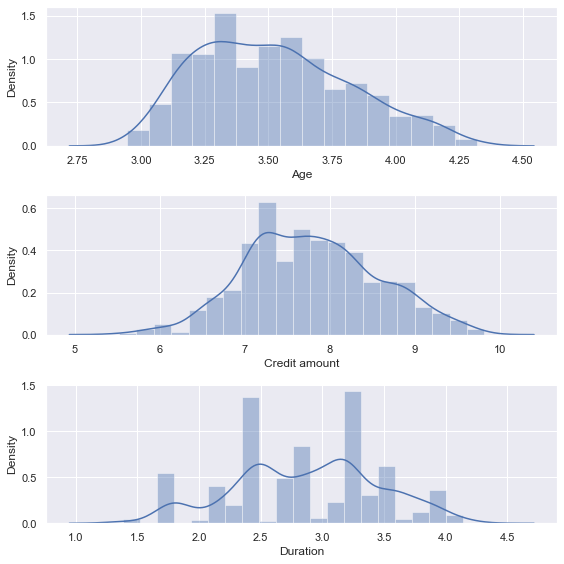

In [47]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

En effet, l'asymétrie a été éliminée.

La prochaine étape sera le centrage et la mise à l'échelle des variables - cela est requis par l'algorithme KMeans. Nous utiliserons pour cela un StandardScaler de la bibliothèque sklearn.

In [48]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

Je vais vérifier comment l'inertie change pour différents nombres de clusters.

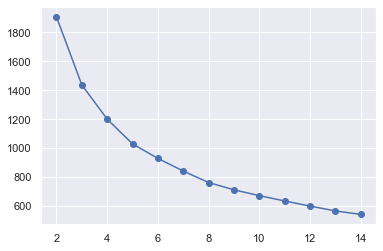

In [49]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

Le graphique ci-dessus montre que l'inertie diminue avec l'augmentation du nombre de clusters.

Cette méthode permet d'évaluer les séparations de cluster et d'ajuster chaque observation dans son propre cluster. Le score le plus élevé est le mieux. J'effectuerai également cette analyse pour diverses graines.

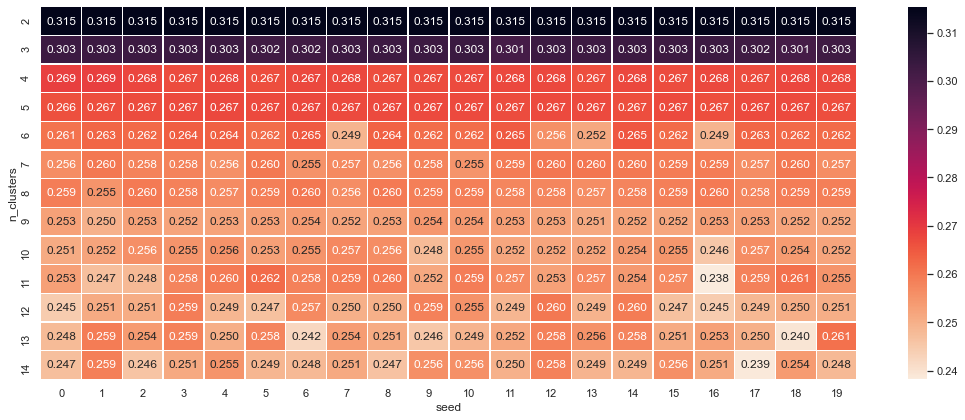

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("Pour n_clusters = ", c" et seed =", r,  "\nLa moyenne silhouette_score est :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

La carte thermique ci-dessus montre les scores de silhouette pour diverses combinaisons d'états aléatoires et de nombre de clusters. Les scores les plus élevés sont pour 2 et 3 grappes et ils sont relativement insensibles aux graines.

Je vais choisir 3 clusters pour avoir plus d'informations sur les données.

In [54]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Ci-dessous, je vais créer un graphique de silhouette pour 3 clusters afin de représenter visuellement l'ajustement de chaque point dans son propre cluster (code modifié de scikit-learn doc).

pour n_clusters = 3  et graines = 19 
La moyenne silhouette_score est : 0.30318933408774545


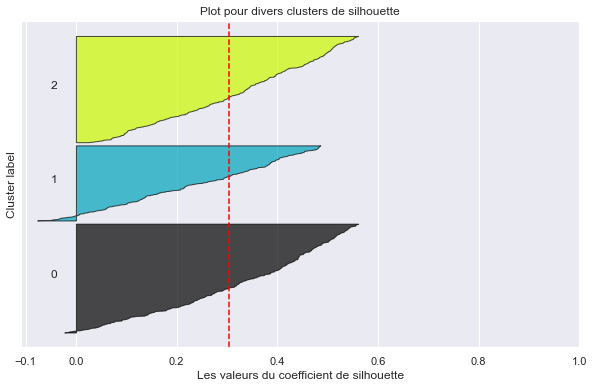

In [56]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("pour n_clusters =", 3," et graines =", r,  "\nLa moyenne silhouette_score est :", silhouette_avg)

# Calculer les scores de silhouette pour chaque échantillon
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Agréger les scores de silhouette pour les échantillons appartenant à
    # cluster i, et triez-les
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label de la silhouette trace avec leur nombre de grappes au milieu
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Calculer le nouveau y_lower pour le prochain plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("Plot pour divers clusters de silhouette")
ax1.set_xlabel("Les valeurs du coefficient de silhouette")
ax1.set_ylabel("Cluster label")
# La ligne verticale pour le score de silhouette moyen de toutes les valeurs
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Je définirai une fonction montrant les clusters sur le nuage de points.

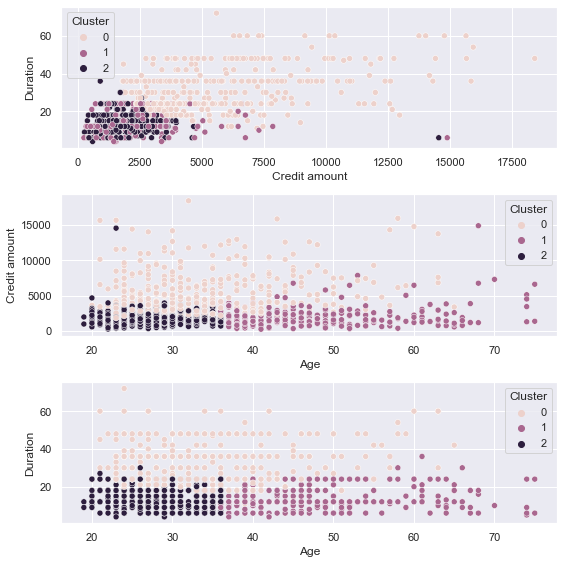

In [57]:
scatters(clustered_data, 'Cluster')

Les graphiques ci-dessus montrent trois clusters créés. Deux du bas montrent une séparation relativement claire des grappes, mais ce n'est pas si évident sur celui du haut.

Je vais maintenant générer un diagramme de carte thermique pour une interprétation plus facile de la segmentation client.

In [58]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


Cluster 0 – montant moyen inférieur du crédit, courte durée, clients plus âgés

Cluster 1 – montant moyen élevé du crédit, longue durée, clients d'âge moyen

Cluster 2 - montant moyen inférieur du crédit, courte durée, jeunes clients

## Clustering Avec Affinity Propagation

Dans cet algorithme, il y a deux paramètres pertinents : la préférence et le dumping. Cela signifie que nous ne définissons pas le nombre initial de clusters, l'algorithme lui-même choisit leur nombre. Je vais corriger le dumping et vérifier le nombre de clusters en fonction du paramètre de préférence.

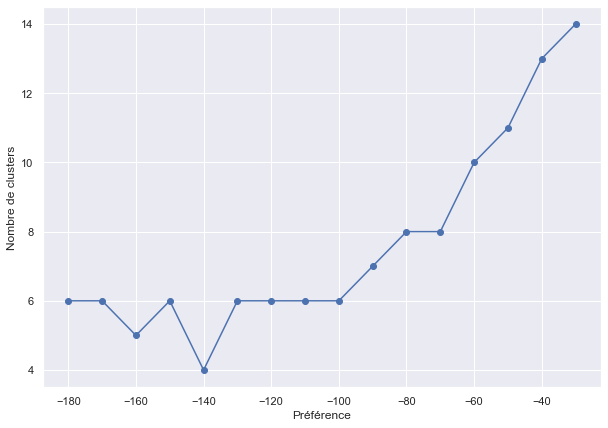

In [59]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Préférence")
plt.ylabel("Nombre de clusters")
plt.plot(preferences,clusters, marker='o')

Avec la diminution de la valeur du paramètre de préférence, le nombre de clusters diminue également et les niveaux pour les très petites valeurs de préférence. Je vais vérifier l'option quatre clusters.

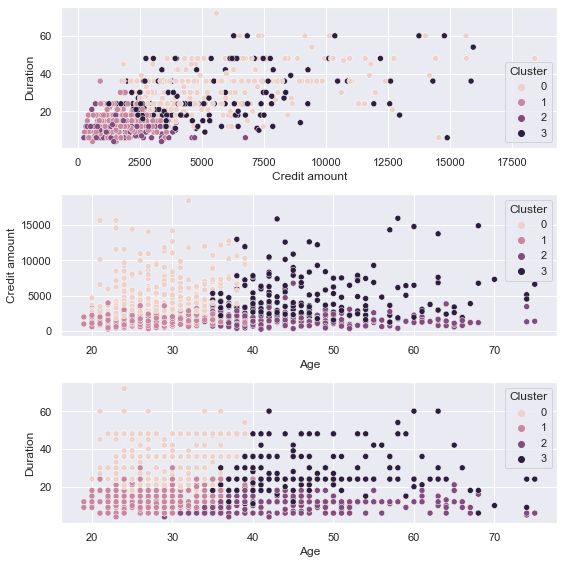

In [60]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [61]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Cluster 0 – montant moyen élevé du crédit, longue durée, clients plus jeunes

Cluster 1 – montant moyen du crédit faible, courte durée, clients plus jeunes

Cluster 2 - montant moyen du crédit faible, courte durée, clients plus âgés

Cluster 3 - montant moyen élevé du crédit, durée intermédiaire, clients plus âgés